# Assignment #7 [ERA v2]

### Abstract
In this assignment we are going to train the MNIST dataset to achieve 99.4% validation accuracy using less than 8000 parameters under 15 epochs.

### Step 1: Import the required modules

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

### Step 2: Preparing the Training and Testing Data

#### 2.0 Find the Mean and Standard Deviation of the Dataset

In [ ]:
simple_transforms = transforms.Compose([ transforms.ToTensor() ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

100%|██████████| 9912422/9912422 [00:00<00:00, 146666024.31it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 28210455.01it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42163385.05it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5340770.61it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


#### 2.1 Train and Test Phase Transformartions

In [ ]:
# Train Phase Transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))  # Mean and Standard Deviation to be calculated of the pixel value
])

# Test Phase Transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

#### 2.2 Dataset and Creating Train/Test Split

In [ ]:
train_data = download_MNIST(True, train_transforms)
test_data = download_MNIST(False, test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 156205121.13it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39101256.88it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33043906.64it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4392559.09it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



#### 2.3 Dataloader Arguments & Test/Train Dataloaders

In [ ]:
# Set the seed for Reproducible results
SEED = 1
set_manualSeed(SEED)

# Dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda_availabilty() else dict(shuffle=True, batch_size=64)

# Train DataLoader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# Test DataLoader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)


#### 2.4: Analyse and View the Data

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


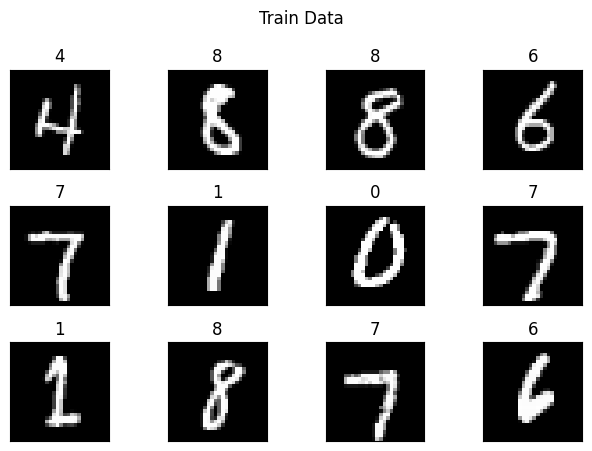

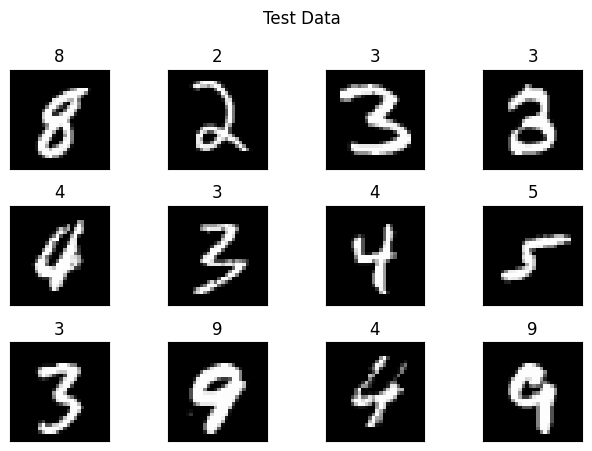

In [ ]:
# Lets check the Statistics of the training dataset
stats_dataset(train_data)

# View the Training and Test Data
view_dataset(train_loader, "Train Data")
view_dataset(test_loader, "Test Data")

### Step 3: Initilizing the model

In [ ]:
from torchsummary import summary
device = selectDevice()
model = Network().to(device)
summary(model, input_size=(1, 28, 28))

Using CUDA!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
            Conv2d-4           [-1, 16, 26, 26]           1,152
       BatchNorm2d-5           [-1, 16, 26, 26]              32
              ReLU-6           [-1, 16, 26, 26]               0
         MaxPool2d-7           [-1, 16, 13, 13]               0
            Conv2d-8            [-1, 8, 13, 13]             128
       BatchNorm2d-9            [-1, 8, 13, 13]              16
             ReLU-10            [-1, 8, 13, 13]               0
           Conv2d-11           [-1, 16, 13, 13]           1,152
      BatchNorm2d-12           [-1, 16, 13, 13]              32
             ReLU-13           [-1, 16, 13, 13]               0
           Conv2d-14       

### Step 4: Training and Testing the model

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

model = Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

criterion = F.nll_loss
num_epoch = 15

for epoch in range(num_epoch):
    print('Epoch : ',epoch)
    train_acc, train_losses = train(model, device, train_loader, optimizer, criterion, train_acc, train_losses)
    test_acc, test_losses = test(model, device, test_loader, criterion, test_acc, test_losses)

Epoch :  0


Train: Loss=0.1519 Batch_id=468 Accuracy=93.09: 100%|██████████| 469/469 [00:16<00:00, 28.48it/s]


Test set: Average loss: 0.0646, Accuracy: 9809/10000 (98.09%)

Epoch :  1


Train: Loss=0.0280 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:17<00:00, 27.21it/s]


Test set: Average loss: 0.0603, Accuracy: 9789/10000 (97.89%)

Epoch :  2


Train: Loss=0.0168 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]


Test set: Average loss: 0.0385, Accuracy: 9880/10000 (98.80%)

Epoch :  3


Train: Loss=0.0378 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:16<00:00, 29.11it/s]


Test set: Average loss: 0.0355, Accuracy: 9889/10000 (98.89%)

Epoch :  4


Train: Loss=0.0122 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 30.46it/s]


Test set: Average loss: 0.0355, Accuracy: 9885/10000 (98.85%)

Epoch :  5


Train: Loss=0.0087 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:15<00:00, 30.43it/s]


Test set: Average loss: 0.0342, Accuracy: 9891/10000 (98.91%)

Epoch :  6


Train: Loss=0.0367 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:16<00:00, 28.99it/s]


Test set: Average loss: 0.0269, Accuracy: 9911/10000 (99.11%)

Epoch :  7


Train: Loss=0.0300 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:15<00:00, 30.31it/s]


Test set: Average loss: 0.0293, Accuracy: 9913/10000 (99.13%)

Epoch :  8


Train: Loss=0.0084 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:15<00:00, 29.93it/s]


Test set: Average loss: 0.0301, Accuracy: 9915/10000 (99.15%)

Epoch :  9


Train: Loss=0.0898 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:15<00:00, 30.19it/s]


Test set: Average loss: 0.0258, Accuracy: 9921/10000 (99.21%)

Epoch :  10


Train: Loss=0.0007 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:15<00:00, 30.49it/s]


Test set: Average loss: 0.0266, Accuracy: 9916/10000 (99.16%)

Epoch :  11


Train: Loss=0.0069 Batch_id=468 Accuracy=99.68: 100%|██████████| 469/469 [00:16<00:00, 28.85it/s]


Test set: Average loss: 0.0276, Accuracy: 9920/10000 (99.20%)

Epoch :  12


Train: Loss=0.0041 Batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:16<00:00, 27.92it/s]


Test set: Average loss: 0.0291, Accuracy: 9912/10000 (99.12%)

Epoch :  13


Train: Loss=0.0027 Batch_id=468 Accuracy=99.77: 100%|██████████| 469/469 [00:16<00:00, 28.31it/s]


Test set: Average loss: 0.0256, Accuracy: 9921/10000 (99.21%)

Epoch :  14


Train: Loss=0.0036 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:15<00:00, 30.55it/s]


Test set: Average loss: 0.0229, Accuracy: 9934/10000 (99.34%)



### Analyze Training, Testing Loss and Accuracy

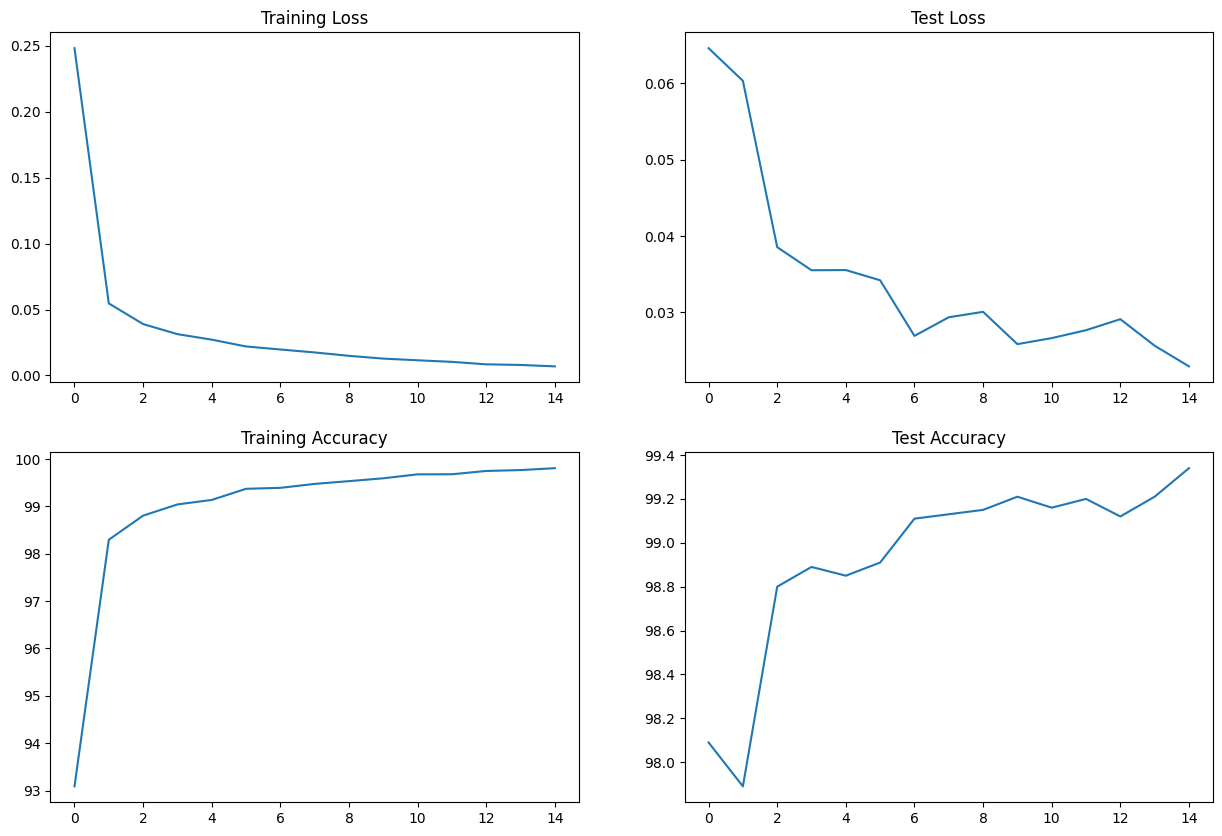

In [ ]:
viewAnalysis(train_losses, train_acc, test_losses, test_acc)